In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Classifying Music Note sounds using Few Shot Deep Learning

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
import math

from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import numpy as np

#### utils

In [403]:
def fft(f):
    Ni = len(f)
    Mi = int(Ni / 2)
    if Mi <= 2:
        return [f[0] + f[1] + f[2] + f[3], 
               f[0] - 1j*f[1] - f[2] + 1j*f[3],
               f[0] - f[1] + f[2] - f[3],
               f[0] + 1j*f[1] - f[2] - 1j*f[3]]
    
    wn = math.cos(2*math.pi/Ni) - 1j*math.sin(2*math.pi/Ni)
    fe = [f[i] for i in range(Ni) if i % 2 == 0]
    fo = [f[i] for i in range(Ni) if i % 2 == 1]
    Fe = fft(fe)
    Fo = fft(fo)
    return [np.around(Fe[i] + (wn**i)*Fo[i], decimals=10) for i in range(Mi)] + [np.around(Fe[i] - (wn**i)*Fo[i], decimals=10) for i in range(Mi)]

def get_audio_data(filename):
    fs = 2**12 # sample rate
    tp = 2 # sampling duration
    N = n = fs*tp # number of samples
    
    # Extract data and sampling rate from file
    recording, fs = librosa.load(filename, sr=fs, duration=tp, mono=True)

    n = len(recording)        
    tp = int(n / fs)

    if tp < 2:
        pad_width = N - recording.shape[0]
        recording = np.pad(recording, pad_width=((0, pad_width),), mode='constant')

        n = len(recording)
        tp = int(n / fs)

    N = fs*tp # number of samples
    x = [np.round(float(recording[i]), 10) for i in range(n)] # input sequence
    return x, tp, n

def get_frequency_amplitude(x, tp, N):
    _X = fft(x) # discrete Fourier transform
    X = [np.round(Xi/N, 10) for Xi in _X] # frequency spectrum
    X_amp = [np.absolute(Xi) for Xi in X] # amplitude spectrum

    M = int(N/2)
    ti = [i*tp/N for i in range(N)]
    fi = [i/tp for i in range(M)]
    X_amp = np.array(X_amp[:M])*2
    
    return ti, fi, X_amp

def extract_features(filepath):
    # try:
    audio_features = get_audio_data(filepath)
    if not audio_features:
        return

    x, tp, N = audio_features
    ti, fi, X_amp = get_frequency_amplitude(x, tp, N)
    return X_amp
#     return fi, X_amp
    
    # except Exception as e:
    #     print("Error encountered while parsing file: ", file_name, e)
    #     return None 
    
def extract_features(file_name):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast', duration=3) 
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    pad_width = 256 - mfccs.shape[1]
    
    mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')     
    return mfccs
    

#### Load Preprocessed data 

In [404]:
# Load various imports 
import pandas as pd
import os
import librosa

# Set the path to the full UrbanSound dataset 
DATA_DIR = os.path.join("data", "guitar_sample")
# DATA_DIR = os.path.join("/content/drive/My Drive/Colab Notebooks/data", "guitar_sample")

# feature list
features = []

# Iterate through each sound file and extract the features 
for folder in tqdm(os.listdir(DATA_DIR)):
    for file in os.listdir(os.path.join(DATA_DIR, folder)):
        class_label = folder
        file_name = os.path.join(os.path.join(DATA_DIR, folder, file))
        
        data = extract_features(file_name)
        if data is None:
            continue
        
        data = np.array(data)
        data = np.expand_dims(data, axis=-1)
        features.append([data, class_label])

# Convert into a Panda dataframe 
featuresdf = pd.DataFrame(features, columns=['feature','class_label'])

print('Finished feature extraction from ', len(featuresdf), ' files') 


Finished feature extraction from  251  files


In [405]:
# featuresdf.feature = featuresdf.feature.apply(lambda xx: xx.reshape((4096, 2)))
featuresdf.feature.iloc[0].shape

(40, 256, 1)

In [406]:
featuresdf.head()

,feature,class_label
0,"[[[-380.9192], [-401.78607], [-466.7695], [-50...",0A
1,"[[[-408.36124], [-431.86826], [-496.21045], [-...",0A
2,"[[[-374.22366], [-398.9928], [-459.22934], [-4...",0A
3,"[[[-367.01163], [-387.91367], [-447.27835], [-...",0A
4,"[[[-368.0699], [-389.0029], [-442.58038], [-47...",0A


In [407]:
from itertools import combinations
from math import factorial

def number_of_combinations(n, r):
    return int(factorial(n) / (factorial(n - r) * factorial(r)))

def prepare_data_pair(X, y, labels):
    data = [[], [], []]
    data_labels = [[], [], []]
    
    for label in labels:
        label = f"1{label}"
        semilabel = f"0{label}"

        indices = np.array(list(range(len(y))))
        similar_indices = indices[y == label]
        train_half_size = number_of_combinations(len(similar_indices), 2)

        semisimilar_indices = indices[y == semilabel][:train_half_size]

        dissimilar_indices = indices[(y != label) & (y != semilabel)]
        np.random.shuffle(dissimilar_indices)

        dissimilar_indices = dissimilar_indices[:train_half_size - len(semisimilar_indices)]
        dissimilar_indices = np.concatenate([semisimilar_indices, dissimilar_indices])

        np.random.shuffle(dissimilar_indices)
        it = iter(dissimilar_indices)

        for i, j in combinations(similar_indices, 2):
            z = next(it)
            for index, value in enumerate([i, j, z]):
                data[index].append(X[value])
                data_labels[index].append(y[value])
            
        print(y[i], y[j], y[z])
    
    data = np.array(data)
    data_labels = np.array(data_labels)
    return data, data_labels

In [408]:
os.listdir(DATA_DIR)

['0A', '0B', '0D', '0EH', '0EL', '0G', '1A', '1B', '1D', '1EH', '1EL', '1G']

In [409]:
# split the dataset 
from sklearn.model_selection import train_test_split 

# Convert features and corresponding classification labels into numpy arrays
input_data = np.array(featuresdf.feature.tolist())
input_labels = np.array(featuresdf.class_label.tolist())

# split train and test data
x_train, x_test, y_train, y_test = train_test_split(input_data, input_labels, test_size=0.2, random_state = 42)

# labels
labels = ["EH", "D", "A", "B", "G", "EL"]

# prepare data set pairs
X, y = prepare_data_pair(x_train, y_train, labels)

1EH 1EH 1G
1D 1D 0EL
1A 1A 0B
1B 1B 1A
1G 1G 1D
1EL 1EL 1D


In [410]:
X.shape, y.shape

((3, 759, 40, 256, 1), (3, 759))

In [411]:
x_train.shape, y_train.shape

((200, 40, 256, 1), (200,))

In [412]:
x_test.shape, y_test.shape

((51, 40, 256, 1), (51,))

In [413]:
for i in range(3):
    print(y[:, i])

['1EH' '1EH' '0G']
['1EH' '1EH' '0B']
['1EH' '1EH' '0EH']


### Convolutional Neural Network (CNN) model architecture 

In [402]:
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Lambda, LayerNormalization, Layer
from tensorflow.keras.layers import Conv1D, MaxPooling1D
# from tensorflow.keras.layers import Conv2D, MaxPooling2D
K.clear_session()

def build_base_network(input_shape):
    model = Sequential()
    
    model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=input_shape))
#     model.add(LayerNormalization(axis=-1))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.25))
    
#     model.add(Conv1D(32, kernel_size=5, activation='relu'))
# #     model.add(LayerNormalization(axis=-1))
#     model.add(MaxPooling1D(pool_size=3))
#     model.add(Dropout(0.25))
    
#     model.add(Conv1D(32, kernel_size=3, activation='relu'))
# #     model.add(LayerNormalization(axis=-1))
#     model.add(MaxPooling1D(pool_size=2))
#     model.add(Dropout(0.25))
    
#     model.add(Conv1D(32, kernel_size=3, activation='relu'))
# #     model.add(LayerNormalization(axis=-1))
#     model.add(MaxPooling1D(pool_size=2))
#     model.add(Dropout(0.25))
    
#     model.add(Conv1D(32, kernel_size=3, activation='relu'))
#     model.add(LayerNormalization(axis=-1))
#     model.add(MaxPooling1D(pool_size=2))
#     model.add(Dropout(0.25))
    
#     model.add(Conv1D(32, kernel_size=3, activation='relu'))
#     model.add(LayerNormalization(axis=-1))
#     model.add(MaxPooling1D(pool_size=2))
#     model.add(Dropout(0.25))

#     model.add(Conv1D(32, kernel_size=3, activation='relu'))
#     model.add(LayerNormalization(axis=-1))
#     model.add(MaxPooling1D(pool_size=2))
#     model.add(Dropout(0.25))

#     model.add(Conv1D(32, kernel_size=3, activation='relu'))
#     model.add(LayerNormalization(axis=-1))
#     model.add(MaxPooling1D(pool_size=2))
#     model.add(Dropout(0.25))
    
#     model.add(Conv1D(32, kernel_size=3, activation='relu'))
#     model.add(LayerNormalization(axis=-1))
#     model.add(MaxPooling1D(pool_size=2))
#     model.add(Dropout(0.25))
    
    model.add(Flatten())
    
#     model.add(Dense(1024))
#     model.add(LayerNormalization())
#     model.add(Dropout(0.3))
    
#     model.add(Dense(512))
# #     model.add(LayerNormalization())
#     model.add(Dropout(0.25))
    
#     model.add(Dense(256))
# #     model.add(LayerNormalization(axis=1))
#     model.add(Dropout(0.25))
    
    model.add(Dense(128))
    return model

def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

### Compiling the model 

For compiling our model, we will use the same three parameters as the previous model: 

In [358]:
# from model import create_model as build_base_network

input_dim = X.shape[2:]

# We only test DenseNet-121 in this script for demo purpose
import tensorflow as tf
# base_network = tf.keras.applications.DenseNet121(
#     include_top=False, weights=None, input_tensor=None, input_shape=input_dim,
#     pooling="max", classes=128
# )

base_network = build_base_network(input_dim)

audio_a = Input(shape=input_dim)
audio_n = Input(shape=input_dim)
audio_p = Input(shape=input_dim)

feat_vecs_a = base_network(audio_a)
feat_vecs_n = base_network(audio_n)
feat_vecs_p = base_network(audio_p)

class TripletLossLayer(Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        a, p, n = inputs
        p_dist = K.sum(K.square(a-p), axis=-1)
        n_dist = K.sum(K.square(a-n), axis=-1)
        return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss

# Layer that computes the triplet loss from anchor, positive and negative embedding vectors
difference = TripletLossLayer(alpha=0.2, name='triplet_loss_layer')([feat_vecs_a, feat_vecs_p, feat_vecs_n])

# initialize training params
epochs = 64
batch_size = 32

optimizer = Adam()
# optimizer = RMSprop()

# initialize the network
model = Model(inputs=[audio_a, audio_p, audio_n], outputs=difference)
model.compile(loss=None, optimizer=optimizer)

In [359]:
input_dim

(40, 1)

In [360]:
# Display model architecture summary 
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40, 1)]      0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 40, 1)]      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 40, 1)]      0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 128)          78080       input_1[0][0]                    
                                                                 input_2[0][0]         

In [361]:
model.layers[3].summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 38, 32)            128       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 19, 32)            0         
_________________________________________________________________
dropout (Dropout)            (None, 19, 32)            0         
_________________________________________________________________
flatten (Flatten)            (None, 608)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               77952     
Total params: 78,080
Trainable params: 78,080
Non-trainable params: 0
_________________________________________________________________


### Training 

Here we will train the model. As training a CNN can take a sigificant amount of time, we will start with a low number of epochs and a low batch size. If we can see from the output that the model is converging, we will increase both numbers.  

In [362]:
from tensorflow.keras.callbacks import ModelCheckpoint 
from time import time

checkpointer = ModelCheckpoint(
    filepath='saved_models/weights.best.basic_cnn.hdf5', 
    verbose=1, 
    save_best_only=True
)

early_stopper = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

start = time()
model.fit(
    [X[0], X[1], X[2]], 
    None, 
    batch_size=batch_size, 
    epochs=epochs, 
    validation_split=0.25,
    callbacks=[checkpointer],#, early_stopper], 
    verbose=1
)

duration = (time() - start)/60
print("Training completed in time: ", duration, "min")

Epoch 1/64
 8/18 [============>.................] - ETA: 0s - loss: 172191.8594
Epoch 00001: val_loss improved from inf to 105.44624, saving model to saved_models\weights.best.basic_cnn.hdf5
18/18 [==============================] - 0s 15ms/step - loss: 132504.4062 - val_loss: 105.4462
Epoch 2/64
12/18 [===================>..........] - ETA: 0s - loss: 57359.7227
Epoch 00002: val_loss did not improve from 105.44624
18/18 [==============================] - 0s 7ms/step - loss: 55508.0508 - val_loss: 124.2717
Epoch 3/64
11/18 [=================>............] - ETA: 0s - loss: 26732.1953
Epoch 00003: val_loss did not improve from 105.44624
18/18 [==============================] - 0s 6ms/step - loss: 29229.8516 - val_loss: 146.4122
Epoch 4/64
13/18 [====================>.........] - ETA: 0s - loss: 16032.5508
Epoch 00004: val_loss did not improve from 105.44624
18/18 [==============================] - 0s 6ms/step - loss: 16663.6484 - val_loss: 221.8480
Epoch 5/64
10/18 [===============>.....

10/18 [===============>..............] - ETA: 0s - loss: 235.3154  
Epoch 00037: val_loss did not improve from 105.44624
18/18 [==============================] - 0s 6ms/step - loss: 130.7308 - val_loss: 430.1978
Epoch 38/64
13/18 [====================>.........] - ETA: 0s - loss: 38.0102   
Epoch 00038: val_loss did not improve from 105.44624
18/18 [==============================] - 0s 6ms/step - loss: 27.4518 - val_loss: 417.4182
Epoch 39/64
12/18 [===================>..........] - ETA: 0s - loss: 150.8260
Epoch 00039: val_loss did not improve from 105.44624
18/18 [==============================] - 0s 6ms/step - loss: 100.5507 - val_loss: 416.4796
Epoch 40/64
11/18 [=================>............] - ETA: 0s - loss: 0.0000e+00
Epoch 00040: val_loss did not improve from 105.44624
18/18 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - val_loss: 416.0234
Epoch 41/64
10/18 [===============>..............] - ETA: 0s - loss: 0.0000e+00
Epoch 00041: val_loss did not improve

#### Evaluation

### Best freq treshold

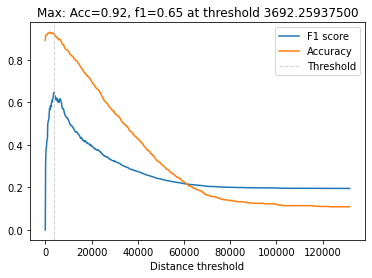

In [363]:
from sklearn.metrics import f1_score, accuracy_score

use_test = True

distances = [] # squared L2 distance between pairs
identical = [] # 1 if same identity, 0 otherwise

if use_test:
    num = len(x_test)
    embedded = model.layers[3].predict(x_test)
    
else:
    num = len(x_train)
    embedded = model.layers[3].predict(x_train)

for i in range(num):
    for j in range(num):
        distances.append(distance(embedded[i], embedded[j]))
        if use_test:
            identical.append(1 if y_test[i] == y_test[j] else 0)
        else:
            identical.append(1 if y_train[i] == y_train[j] else 0)
            
distances = np.array(distances)
identical = np.array(identical)

min_threshold = min(distances)
max_threshold = max(distances)
threshold_step = (max_threshold - min_threshold)/1000
thresholds = np.arange(min_threshold, max_threshold, threshold_step)

f1_scores = [f1_score(identical, distances < t) for t in thresholds]
acc_scores = [accuracy_score(identical, distances < t) for t in thresholds]

# max f1
opt_idx = np.argmax(f1_scores)
opt_f1 = np.max(f1_scores)

# Threshold at maximal F1 score
opt_tau = thresholds[opt_idx]

# Accuracy at maximal F1 score
opt_acc = accuracy_score(identical, distances < opt_tau)

# Plot F1 score and accuracy as function of distance threshold
plt.plot(thresholds, f1_scores, label='F1 score');
plt.plot(thresholds, acc_scores, label='Accuracy');
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title(f'Max: Acc={opt_acc:.2f}, f1={opt_f1:.2f} at threshold {opt_tau:.8f}');
plt.xlabel('Distance threshold')
plt.legend();

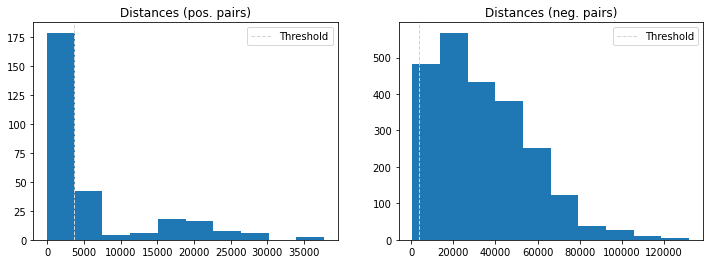

In [364]:
dist_pos = distances[identical == 1]
dist_neg = distances[identical == 0]

plt.figure(figsize=(12,4))

plt.subplot(121)
plt.hist(dist_pos)
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title('Distances (pos. pairs)')
plt.legend();

plt.subplot(122)
plt.hist(dist_neg)
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title('Distances (neg. pairs)')
plt.legend();

### Testing Evaluation

In [365]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report

distances = [] # squared L2 distance between pairs
identical = [] # 1 if same identity, 0 otherwise
prediction = []

num = len(x_test)
embedded = model.layers[3].predict(x_test)

for i in range(num):
    for j in range(num):
        distances.append(distance(embedded[i], embedded[j]))
        identical.append(1 if y_test[i] == y_test[j] else 0)
        prediction.append(1 if distances[-1] < opt_tau else 0)
        
distances = np.array(distances)
identical = np.array(identical)
prediction = np.array(prediction)

print("accuracy =", accuracy_score(identical, prediction))

print("\nclassification_report")
print("========================")
print(classification_report(identical, prediction))

print("\nconfusion matrix")
print("========================")
print(confusion_matrix(identical, prediction))

accuracy = 0.9246443675509419

classification_report
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      2320
           1       0.66      0.64      0.65       281

    accuracy                           0.92      2601
   macro avg       0.81      0.80      0.80      2601
weighted avg       0.92      0.92      0.92      2601


confusion matrix
[[2226   94]
 [ 102  179]]


### Testing (new data) Evaluation

In [366]:
x_test_sample = []
y_test_sample = []

sample_dirs = ["EH", "D", "A", "B", "G", "EL"]
# sample_dirs = ["A"]

sample_label = "A"
sample_filepath = os.path.join("data", "sampleA.wav")
sample_vector = extract_features(sample_filepath)
sample_vector = np.array(sample_vector).reshape(1, 40, 1)
sample_embedded = model.layers[3].predict(sample_vector)

for label in tqdm(sample_dirs):
    print(label, end=", ")
    labeldir= os.path.join("data", "old_guitar_sample", label)

    for filename in (os.listdir(labeldir)):
        anchor_filepath = os.path.join("data", "old_guitar_sample", label, filename)
        
        x_test_sample.append(extract_features(anchor_filepath).reshape((-1, 1)))
        y_test_sample.append(label)

print()
x_test_sample = np.array(x_test_sample)
y_test_sample = np.array(y_test_sample)

print(x_test_sample.shape)

EH, D, A, B, G, EL, 

(58, 40, 1)


In [367]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report

distances = [] # squared L2 distance between pairs
identical = [] # 1 if same identity, 0 otherwise
prediction = []

num = len(x_test_sample)
embedded = model.layers[3].predict(x_test_sample)

for i in range(num):
    for j in range(num):
        distances.append(distance(embedded[i], embedded[j]))
        identical.append(1 if y_test_sample[i] == y_test_sample[j] else 0)
        prediction.append(1 if distances[-1] < opt_tau else 0)
        
distances = np.array(distances)
identical = np.array(identical)
prediction = np.array(prediction)

print("accuracy =", accuracy_score(identical, prediction))

print("\nclassification_report")
print("========================")
print(classification_report(identical, prediction))

print("\nconfusion matrix")
print("========================")
print(confusion_matrix(identical, prediction))

accuracy = 0.9839476813317479

classification_report
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2802
           1       0.97      0.93      0.95       562

    accuracy                           0.98      3364
   macro avg       0.98      0.96      0.97      3364
weighted avg       0.98      0.98      0.98      3364


confusion matrix
[[2788   14]
 [  40  522]]


### Testing (sample) Evaluation

In [368]:
x_test_sample = []
y_test_sample = []

sample_dirs = ["1EH", "1D", "1A", "1B", "1G", "1EL"]

sample_label = "A"
sample_filepath = os.path.join("data", "sampleA.wav")
sample_vector = extract_features(sample_filepath).reshape((1, -1, 1))
sample_embedded = model.layers[3].predict(sample_vector)

for label in tqdm(sample_dirs):
    print(label, end=", ")
    labeldir= os.path.join(DATA_DIR, label)

    for filename in (os.listdir(labeldir)):
        anchor_filepath = os.path.join(DATA_DIR, label, filename)
        
        x_test_sample.append(extract_features(anchor_filepath).reshape((-1, 1)))
        y_test_sample.append(1 if label.startswith("1") and label.endswith(sample_label) else 0)

print()
x_test_sample = np.array(x_test_sample)
y_test_sample = np.array(y_test_sample)

print(x_test_sample.shape)

1EH, 1D, 1A, 1B, 1G, 1EL, 

(118, 40, 1)


In [369]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report

distances = [] # squared L2 distance between pairs
prediction = []

num = len(x_test_sample)
embedded = model.layers[3].predict(x_test_sample)

for i in range(num):
    distances.append(distance(embedded[i], sample_embedded))
    prediction.append(1 if distances[-1] < opt_tau else 0)

identical = y_test_sample
distances = np.array(distances)
prediction = np.array(prediction)

print("accuracy =", accuracy_score(identical, prediction))

print("\nclassification_report")
print("========================")
print(classification_report(identical, prediction))

print("\nconfusion matrix")
print("========================")
print(confusion_matrix(identical, prediction))

accuracy = 0.8305084745762712

classification_report
              precision    recall  f1-score   support

           0       0.83      1.00      0.91        98
           1       0.00      0.00      0.00        20

    accuracy                           0.83       118
   macro avg       0.42      0.50      0.45       118
weighted avg       0.69      0.83      0.75       118


confusion matrix
[[98  0]
 [20  0]]


c:\users\christian\.virtualenvs\guitar_audio_sample_detection\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [370]:
prediction.shape, identical.shape

((118,), (118,))

In [ ]:
# weights path
# weights_path = os.path.join("C:\\Users\\christian\\Documents\\christian\\work\\python\\guitar_music_note_recognizer\\music_note_recognizer\\static\\music_note_recognizer\\weights", f'{label}_weights.h5')
# weights_path = "saved_models/triplet_128_32.h5"

# load weights
# model.save_weights(weights_path)